In [1]:
from google.colab import files
uploaded = files.upload()

Saving Aliases.csv to Aliases.csv
Saving EmailReceivers.csv to EmailReceivers.csv
Saving Emails.csv to Emails.csv
Saving Persons.csv to Persons.csv


In [23]:
import pandas as pd

In [24]:
import networkx as nx

In [25]:
import numpy as np

In [26]:
from collections import defaultdict

In [27]:
import matplotlib.pyplot as plt

In [28]:
# load_data
emails = pd.read_csv("Emails.csv")
file_aliaes = pd.read_csv("Aliases.csv")

In [29]:
file_person = pd.read_csv("Persons.csv")

In [ ]:
file_aliaes.head(20)

In [31]:
aliases = {}
for index, row in file_aliaes.iterrows():
  aliases[row['Alias']] = row['PersonId']

In [ ]:
file_person.head(10)

In [33]:
persons = {}
for index, row in file_person.iterrows():
  persons[row['Id']] = row['Name']

In [34]:
def unify_name(name):
  # 姓名转小写
  name = str(name).lower()
  # 去掉 @ ， 后面的内容
  name = name.replace(",","").split("@")[0]
  # 别名替换
  if name in aliases.keys():
    return persons[aliases[name]]
  return name

In [ ]:
emails.head()

In [36]:
emails.MetadataFrom = emails.MetadataFrom.apply(unify_name)
emails.MetadataTo = emails.MetadataTo.apply(unify_name)

In [89]:
def show_graph(graph, layout='spring_layout'):
  # layout 直接写死了，实际上还有:circular_layout（在一个圆环上均匀分布节点），random_layout（随机分布节点 ），shell_layout（节点都在同心圆上）。
  if layout == 'circular_layout':
    positions = nx.circular_layout(graph)
  else:
    positions = nx.spring_layout(graph)
  
  # 设置网络的节点大小，大小与 pagerank 有关，放大所以×20000
  nodesize = [x['pagerank']*20000 for v,x in graph.nodes(data=True)]
  # 设置网络图的边的长度
  edgesize = [np.sqrt(e[2]['weight']) for e in graph.edges(data=True)]
  # 绘制节点
  nx.draw_networkx_nodes(graph, positions, node_size=nodesize, alpha=0.4)
  # 绘制边
  # nx.draw_networkx_edges(graph, positions, edgelist=edgesize, alpha=0.2)
  nx.draw_networkx_edges(graph, positions, alpha=0.2)

  # 绘制节点的 label
  nx.draw_networkx_labels(graph, positions, font_size=10)
  # 输出
  plt.show()

In [39]:
# 邮件的发送者和接收者的邮件往来可能不止一次，我们需要用两者之间邮件往来的次数计算这两者之间边的权重，所以我用 edges_weights_temp 数组存储权重。而上面介绍过在 NetworkX 中添加权重边（即使用 add_weighted_edges_from 函数）的时候，接受的是 u、v、w 的三元数组，因此我们还需要对格式进行转换

In [40]:
# 设置边的权重等于发邮件的次数
edges_weights_temp = defaultdict(list)

In [42]:
type(edges_weights_temp)

collections.defaultdict

In [43]:
for row in zip(emails.MetadataFrom, emails.MetadataTo, emails.RawText):
  temp = (row[0], row[1])
  if temp not in edges_weights_temp:
    edges_weights_temp[temp] = 1 
  else:
    edges_weights_temp[temp] = edges_weights_temp[temp] + 1

In [45]:
# (from, to), weight --> from, to, weight
edges_weights = [(key[0], key[1], val) for key, val in edges_weights_temp.items()]

In [ ]:
edges_weights

In [68]:
# 创建一个有向图
graph = nx.DiGraph()

In [70]:
# set from, to, weights
graph.add_weighted_edges_from(edges_weights)

In [71]:
# 计算 PR 值
pagerank = nx.pagerank(graph)
# 把 PR 值设置为节点的属性
nx.set_node_attributes(graph, name='pagerank', values=pagerank)

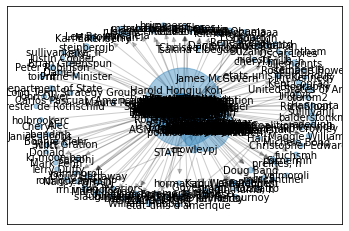

In [90]:
show_graph(graph)

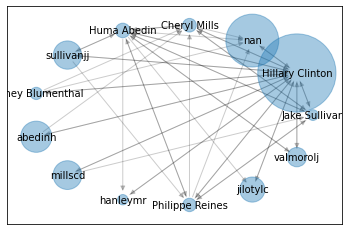

In [91]:
# 将完整的进行精简
# 设置阈值
pagerank_threshold = 0.005
# copy 
small_graph = graph.copy()
# delete those points pr<0.005
for n, p_rank in graph.nodes(data=True):
  if p_rank['pagerank'] < pagerank_threshold:
    small_graph.remove_node(n)
# 画图，采用 circular_layout 让筛出来的点组成一个圆
show_graph(small_graph, 'circular_layout')

In [86]:
# 创建有向图
G = nx.DiGraph()
# 有向图之间边的关系
edges = [("A", "B"), ("A", "C"), ("A", "D"), ("B", "A"), ("B", "D"), ("C", "A"), ("D", "B"), ("D", "C")]
for edge in edges:
    G.add_edge(edge[0], edge[1])
pagerank_list = nx.pagerank(G, alpha=0.85)
print("pagerank 值是：", pagerank_list)

pagerank 值是： {'A': 0.3245609358176831, 'B': 0.22514635472743894, 'C': 0.22514635472743894, 'D': 0.22514635472743894}
